In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Read the CSV files
Pennsylvania_Train_2022 = pd.read_csv("C:\\Users\\mahya\\OneDrive - University of Nebraska-Lincoln\\University of nebraska-lincoln\\Papers\\Predicting_Crash_Injury severity_Truck_Involved\\Pennsylvania Data\\Statewide_2022\\FLAG_2022.csv")

Pennsylvania_Valid_2023 = pd.read_csv("C:\\Users\\mahya\\OneDrive - University of Nebraska-Lincoln\\University of nebraska-lincoln\\Papers\\Predicting_Crash_Injury severity_Truck_Involved\\Pennsylvania Data\\Statewide_2023\\FLAG_2023.csv")


In [18]:
# Remove useless column from the train 2022 data
Train_2022 = Pennsylvania_Train_2022.drop(columns=['CRN','FATAL','FATAL_OR_SUSP_SERIOUS_INJ','INJURY','NHTSA_AGG_DRIVING',
                                                   'POSSIBLE_INJURY','PROPERTY_DAMAGE_ONLY','PSP_REPORTED',
                                                   'SUSPECTED_MINOR_INJURY','SUSPECTED_SERIOUS_INJURY','VEHICLE_TOWED',
                                                   'VULNERABLE_ROAD_USER_FATAL','ATV','BACKUP_CONGESTION','BACKUP_PRIOR',
                                                   'BICYCLE','DRIVER_16YR','HIT_DEER','HORSE_BUGGY',
                                                   'MARIJUANA_DRUGGED_DRIVER','PHANTOM_VEHICLE','ROUNDABOUT','SCHOOL_BUS',
                                                   'SCHOOL_BUS_UNIT','SCHOOL_ZONE','SHLDR_RELATED','SNOWMOBILE','TRAIN',
                                                   'TROLLEY','UNDERAGE_DRNK_DRV','UNLICENSED','BACKUP_NONRECURRING',
                                                   'MC_DRINKING_DRIVER','OPIOID_RELATED'])


# Remove useless column from the test 2023 data
Valid_2023 = Pennsylvania_Valid_2023.drop(columns=['CRN','FATAL','FATAL_OR_SUSP_SERIOUS_INJ','INJURY','NHTSA_AGG_DRIVING',
                                                   'POSSIBLE_INJURY','PROPERTY_DAMAGE_ONLY','PSP_REPORTED',
                                                   'SUSPECTED_MINOR_INJURY','SUSPECTED_SERIOUS_INJURY','VEHICLE_TOWED',
                                                   'VULNERABLE_ROAD_USER_FATAL','ATV','BACKUP_CONGESTION','BACKUP_PRIOR',
                                                   'BICYCLE','DRIVER_16YR','HIT_DEER','HORSE_BUGGY',
                                                   'MARIJUANA_DRUGGED_DRIVER','PHANTOM_VEHICLE','ROUNDABOUT','SCHOOL_BUS',
                                                   'SCHOOL_BUS_UNIT','SCHOOL_ZONE','SHLDR_RELATED','SNOWMOBILE','TRAIN',
                                                   'TROLLEY','UNDERAGE_DRNK_DRV','UNLICENSED','BACKUP_NONRECURRING',
                                                   'MC_DRINKING_DRIVER','OPIOID_RELATED'])



############################################################################################################################
# Drop high corrolation columns from the train 2022 data
Train_2022 = Train_2022.drop(columns=['ALCOHOL_RELATED','DEER_RELATED','IMPAIRED_DRIVER','DRUG_RELATED',
                                      'ILLEGAL_DRUG_RELATED','NON_INTERSECTION','MARIJUANA_RELATED',
                                      'SINGLE_VEHICLE','PEDESTRIAN','TRAIN_TROLLEY','SUDDEN_DEER','RURAL',
                                      'LOCAL_ROAD_ONLY','CORE_NETWORK','DRIVER_65_74YR','HIT_FIXED_OBJECT',
                                      'HAZARDOUS_TRUCK','COMM_VEHICLE','SV_RUN_OFF_RD'])


# Drop high corrolation columns from the train 2022 data
Valid_2023 = Valid_2023.drop(columns=['ALCOHOL_RELATED','DEER_RELATED','IMPAIRED_DRIVER','DRUG_RELATED',
                                      'ILLEGAL_DRUG_RELATED','NON_INTERSECTION','MARIJUANA_RELATED',
                                      'SINGLE_VEHICLE','PEDESTRIAN','TRAIN_TROLLEY','SUDDEN_DEER','RURAL',
                                      'LOCAL_ROAD_ONLY','CORE_NETWORK','DRIVER_65_74YR','HIT_FIXED_OBJECT',
                                      'HAZARDOUS_TRUCK','COMM_VEHICLE','SV_RUN_OFF_RD'])

In [19]:
# Drop the 'CRN' column if it exists
if 'CRN' in Train_2022.columns:
    Train_2022 = Train_2022.drop(columns=['CRN'])

# Calculate the correlation matrix
correlation_matrix = Train_2022.corr()

# Find pairs with correlation greater than 0.8
correlation_pairs = correlation_matrix.abs().unstack().reset_index()
correlation_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
correlation_pairs = correlation_pairs[correlation_pairs['Variable1'] != correlation_pairs['Variable2']]
high_correlation_pairs = correlation_pairs[correlation_pairs['Correlation'] > 0.7]

# Drop duplicate pairs
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs['Variable1'] < high_correlation_pairs['Variable2']]

# Display the result
print(high_correlation_pairs)

Empty DataFrame
Columns: [Variable1, Variable2, Correlation]
Index: []


# Split data to Truck and non-Truck vehicle involved in crashes

In [20]:
# Truck data

#Truck data for train 2022
filter_truck_2022 = Train_2022['HVY_TRUCK_RELATED'] == 1
Train_2022_Truck = Train_2022[filter_truck_2022]
Train_2022_Truck = Train_2022_Truck.dropna()
Train_2022_Truck = Train_2022_Truck.drop('HVY_TRUCK_RELATED', axis=1)

#Truck data for test 2023
filter_truck_2023 = Valid_2023['HVY_TRUCK_RELATED'] == 1
Valid_2023_Truck = Valid_2023[filter_truck_2023]
Valid_2023_Truck = Valid_2023_Truck.dropna()
Valid_2023_Truck = Valid_2023_Truck.drop('HVY_TRUCK_RELATED', axis=1)
#Valid_2023_Truck


############################################################################################################################

# Non-Truck data

#NonTruck data for train 2022
filter_Nontruck_2022 = Train_2022['HVY_TRUCK_RELATED'] != 1
Train_2022_NonTruck = Train_2022[filter_Nontruck_2022]
Train_2022_NonTruck = Train_2022_NonTruck.dropna()
Train_2022_NonTruck = Train_2022_NonTruck.drop('HVY_TRUCK_RELATED', axis=1)
#Train_2022_NonTruck

#NonTruck data for test 2023
filter_Nontruck_2023 = Valid_2023['HVY_TRUCK_RELATED'] != 1
Valid_2023_NonTruck = Valid_2023[filter_Nontruck_2023]
Valid_2023_NonTruck = Valid_2023_NonTruck.dropna()
Valid_2023_NonTruck = Valid_2023_NonTruck.drop('HVY_TRUCK_RELATED', axis=1)
#Valid_2023_NonTruck

In [21]:
# Count the occurrences of the value 1 in each column
count_ones = Train_2022_Truck.apply(lambda x: (x == 1).sum())

# Filter columns with fewer than 50 occurrences of 1
columns_with_few_ones = count_ones[count_ones < 50]

# Print the columns and their counts
print(columns_with_few_ones)


Series([], dtype: int64)


# Develop Discriminant Analysis model on truck data

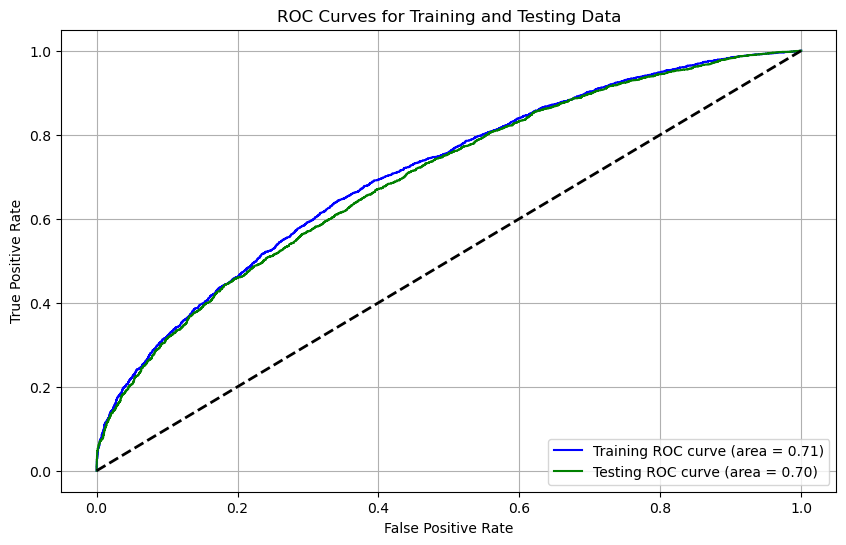

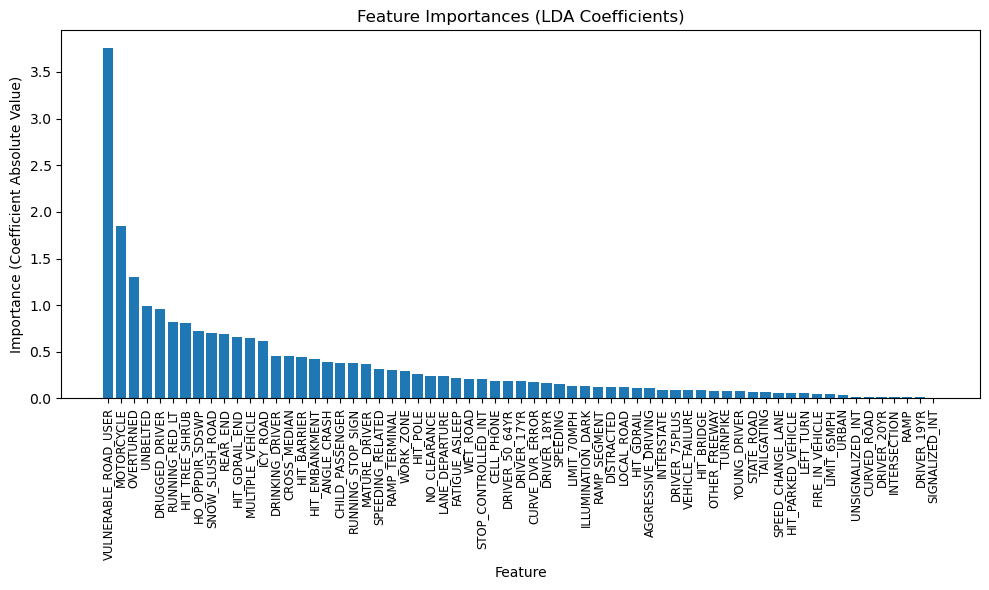

In [22]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Separate features and target variable from training data
X_train_truck = Train_2022_Truck.drop(columns=['INJURY_OR_FATAL'])
y_train_truck = Train_2022_Truck['INJURY_OR_FATAL']

# Separate features and target variable from testing data
X_test_truck = Valid_2023_Truck.drop(columns=['INJURY_OR_FATAL'])
y_test_truck = Valid_2023_Truck['INJURY_OR_FATAL']

# Initialize and train the Linear Discriminant Analysis model
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_truck, y_train_truck)

# Predict probabilities for both training and testing datasets
y_train_truck_prob = lda_model.predict_proba(X_train_truck)[:, 1]
y_test_truck_prob = lda_model.predict_proba(X_test_truck)[:, 1]

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_truck, y_train_truck_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_truck, y_test_truck_prob)

# Calculate AUC scores
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (area = {auc_test:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get feature importances (coefficients) and sort them
coefficients = np.abs(lda_model.coef_[0])
sorted_idx = np.argsort(coefficients)[::-1]
feature_names = X_train_truck.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), coefficients[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_idx], rotation=90, fontsize='small')
plt.xlabel('Feature')
plt.ylabel('Importance (Coefficient Absolute Value)')
plt.title('Feature Importances (LDA Coefficients)')
plt.tight_layout()
plt.show()

# Develop Discriminant Analysis model on Non truck data

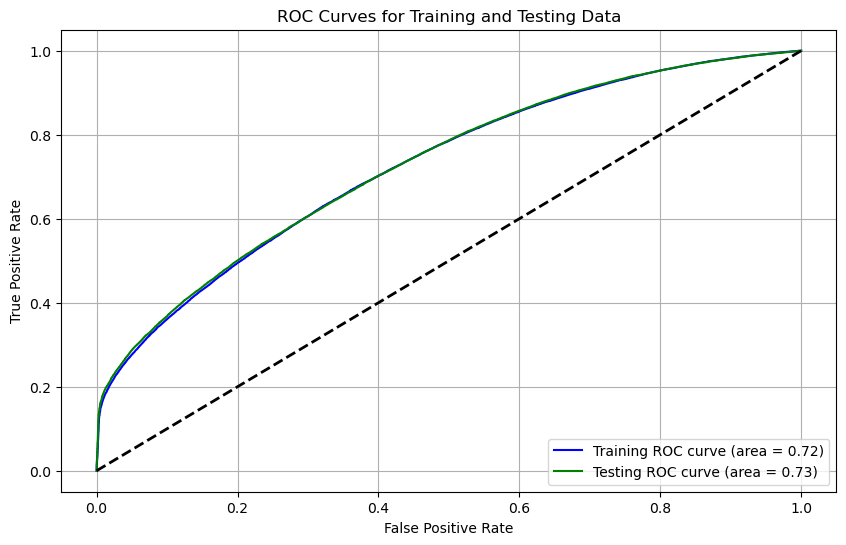

In [23]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Separate features and target variable from training data
X_train_Notruck = Train_2022_NonTruck.drop(columns=['INJURY_OR_FATAL'])
y_train_Notruck = Train_2022_NonTruck['INJURY_OR_FATAL']

# Separate features and target variable from testing data
X_test_Notruck = Valid_2023_NonTruck.drop(columns=['INJURY_OR_FATAL'])
y_test_Notruck = Valid_2023_NonTruck['INJURY_OR_FATAL']

# Initialize and train the Linear Discriminant Analysis model
lda_model_nontruck = LinearDiscriminantAnalysis()
lda_model_nontruck.fit(X_train_Notruck, y_train_Notruck)

# Predict probabilities for both training and testing datasets
y_train_Notruck_prob = lda_model_nontruck.predict_proba(X_train_Notruck)[:, 1]
y_test_Notruck_prob = lda_model_nontruck.predict_proba(X_test_Notruck)[:, 1]

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_Notruck, y_train_Notruck_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_Notruck, y_test_Notruck_prob)

# Calculate AUC scores
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (area = {auc_test:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate score on truck dataset

In [24]:
# Predict probabilities for the training dataset
prob_train = lda_model_nontruck.predict_proba(X_train_truck)[:, 1]

# Add the probabilities as a new column to the Train_2022_Truck dataset
Train_2022_Truck['nontruck_score'] = prob_train

# Predict probabilities for the testing dataset
prob_test = lda_model_nontruck.predict_proba(X_test_truck)[:, 1]

# Add the probabilities as a new column to the Test_2023_Truck dataset
Valid_2023_Truck['nontruck_score'] = prob_test


# Find ROC for truck dataset with non-truck score variable

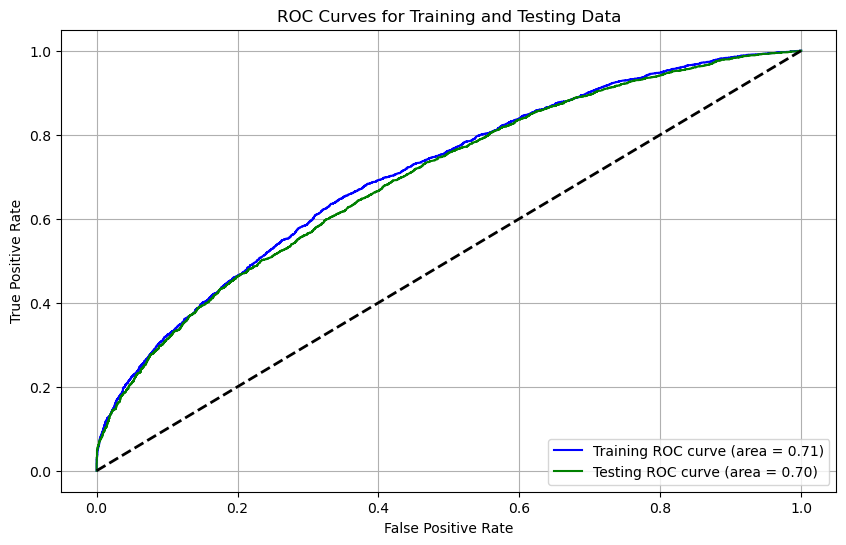

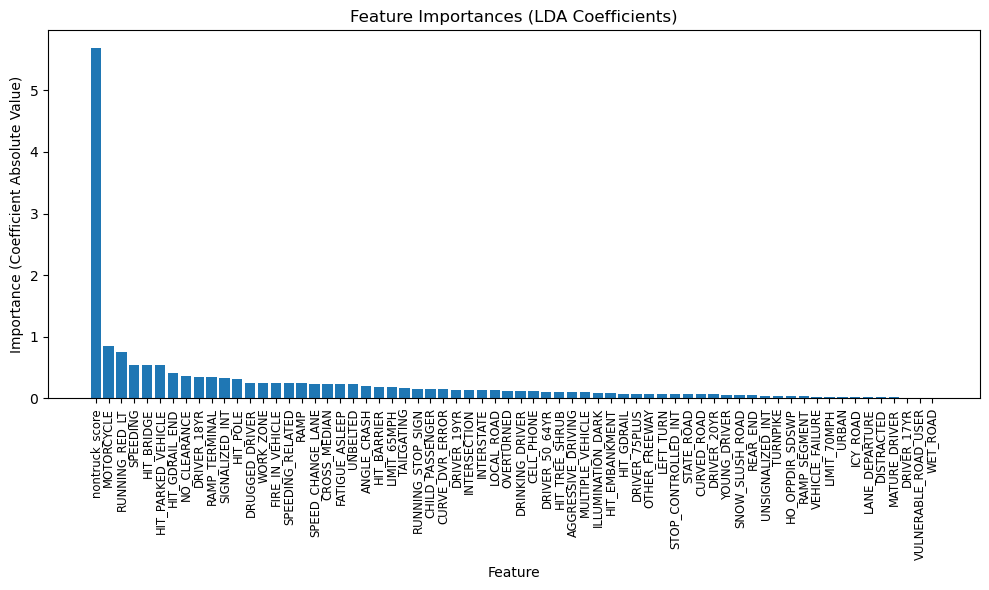

In [25]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
                                      
                                         
# Separate features and target variable from training data
X_train_truck = Train_2022_Truck.drop(columns=['INJURY_OR_FATAL'])
y_train_truck = Train_2022_Truck['INJURY_OR_FATAL']

# Separate features and target variable from testing data
X_test_truck = Valid_2023_Truck.drop(columns=['INJURY_OR_FATAL'])
y_test_truck = Valid_2023_Truck['INJURY_OR_FATAL']

# Initialize and train the Linear Discriminant Analysis model
lda_model_truck = LinearDiscriminantAnalysis()
lda_model_truck.fit(X_train_truck, y_train_truck)

# Predict probabilities for both training and testing datasets
y_train_truck_prob = lda_model_truck.predict_proba(X_train_truck)[:, 1]
y_test_truck_prob = lda_model_truck.predict_proba(X_test_truck)[:, 1]

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_truck, y_train_truck_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_truck, y_test_truck_prob)

# Calculate AUC scores
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (area = {auc_test:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get feature importances (coefficients) and sort them
coefficients = np.abs(lda_model_truck.coef_[0])
sorted_idx = np.argsort(coefficients)[::-1]
feature_names = X_train_truck.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), coefficients[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_idx], rotation=90, fontsize='small')
plt.xlabel('Feature')
plt.ylabel('Importance (Coefficient Absolute Value)')
plt.title('Feature Importances (LDA Coefficients)')
plt.tight_layout()
plt.show()

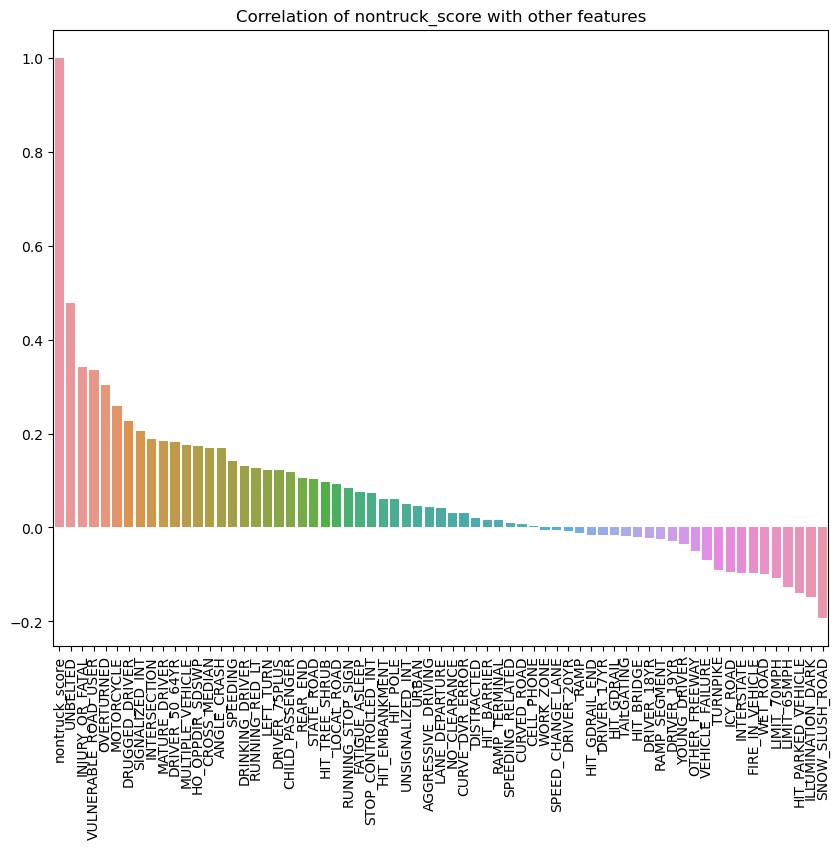

Top 5 correlated features with nontruck_score:
 nontruck_score          1.000000
UNBELTED                0.477193
INJURY_OR_FATAL         0.341515
VULNERABLE_ROAD_USER    0.334262
OVERTURNED              0.303258
Name: nontruck_score, dtype: float64

Bottom 5 correlated features with nontruck_score:
 LIMIT_70MPH          -0.107839
LIMIT_65MPH          -0.126723
HIT_PARKED_VEHICLE   -0.139751
ILLUMINATION_DARK    -0.147590
SNOW_SLUSH_ROAD      -0.191931
Name: nontruck_score, dtype: float64


In [26]:
import seaborn as sns

# Check correlation of nontruck_score with other features
correlations = Train_2022_Truck.corr()
nontruck_corr = correlations['nontruck_score'].sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=nontruck_corr.index, y=nontruck_corr.values)
plt.xticks(rotation=90)
plt.title('Correlation of nontruck_score with other features')
plt.show()

# Print top 5 and bottom 5 correlated features with nontruck_score
print("Top 5 correlated features with nontruck_score:\n", nontruck_corr.head())
print("\nBottom 5 correlated features with nontruck_score:\n", nontruck_corr.tail())


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predict the classes for the test set
y_test_truck_pred = lda_model_truck.predict(X_test_truck)

# Calculate additional performance metrics
precision = precision_score(y_test_truck, y_test_truck_pred)
recall = recall_score(y_test_truck, y_test_truck_pred)
f1 = f1_score(y_test_truck, y_test_truck_pred)
accuracy = accuracy_score(y_test_truck, y_test_truck_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")


Precision: 0.65
Recall: 0.42
F1-Score: 0.51
Accuracy: 0.66


# Develop random forest model on truck dataset with non-truck score variable

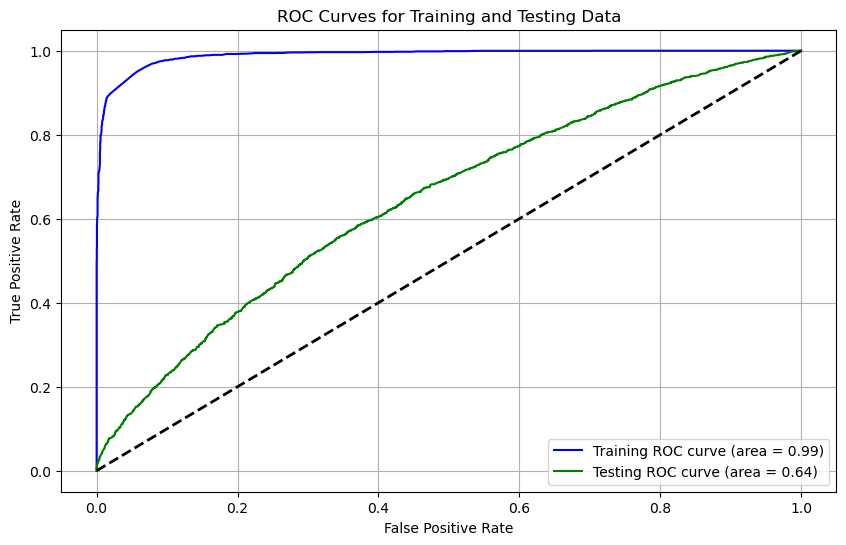

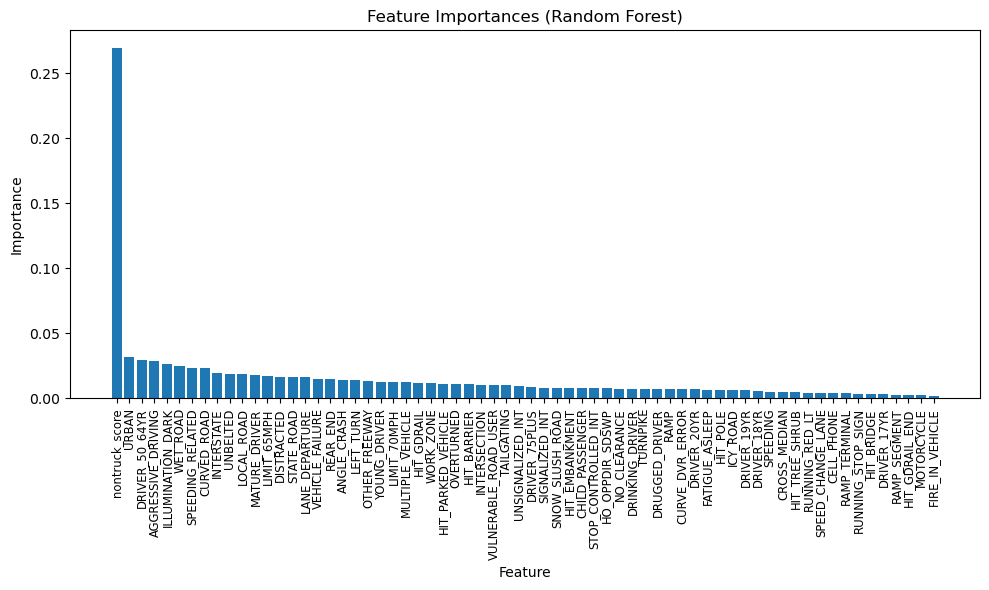

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#############################################################################################################################
# Drop nontruck_score feature to compare ROCs

#Train_2022_Truck = Train_2022_Truck.drop(columns=['nontruck_score'])
#Valid_2023_Truck = Valid_2023_Truck.drop(columns=['nontruck_score'])
#############################################################################################################################
# Separate features and target variable from training data

X_train_truck = Train_2022_Truck.drop(columns=['INJURY_OR_FATAL'])
y_train_truck = Train_2022_Truck['INJURY_OR_FATAL']

# Separate features and target variable from testing data
X_test_truck = Valid_2023_Truck.drop(columns=['INJURY_OR_FATAL'])
y_test_truck = Valid_2023_Truck['INJURY_OR_FATAL']

# Initialize and train the Random Forest model
rf_model_truck = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_truck.fit(X_train_truck, y_train_truck)

# Predict probabilities for both training and testing datasets
y_train_truck_prob = rf_model_truck.predict_proba(X_train_truck)[:, 1]
y_test_truck_prob = rf_model_truck.predict_proba(X_test_truck)[:, 1]

# Calculate ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train_truck, y_train_truck_prob)
fpr_test, tpr_test, _ = roc_curve(y_test_truck, y_test_truck_prob)

# Calculate AUC scores
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (area = {auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (area = {auc_test:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get feature importances and sort them
importances = rf_model_truck.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
feature_names = X_train_truck.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), importances[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), np.array(feature_names)[sorted_idx], rotation=90, fontsize='small')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()
